In [53]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()

In [54]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [55]:
print(data["DESCR"])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_img(img):
    img = img.reshape((64, 64))
    plt.imshow(img, cmap="gray")
    plt.axis("off")

In [57]:
X = data["data"]
y = data["target"]

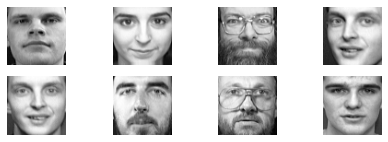

In [58]:
import numpy as np

# 4 x 4
idxs = [np.random.randint(len(X)) for _ in range(8)]

for idx in range(1, 9):
    plt.subplot(4, 4, idx)
    plot_img(X[idxs[idx - 1]])

plt.tight_layout()
plt.show()

In [59]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)

train_val_idx, test_idx = next(strat_split.split(X, y))
X_train_val = X[train_val_idx]
y_train_val = y[train_val_idx]
X_test = X[test_idx]
y_test = y[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=60, random_state=42)

train_idx, val_idx = next(strat_split.split(X_train_val, y_train_val))
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]

In [60]:
print(X_train.shape, X_test.shape, X_val.shape)

(300, 4096) (40, 4096) (60, 4096)


In [61]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [62]:
pca.n_components_

210

In [63]:
from sklearn.cluster import KMeans

kms = []
for n_clusters in range(5, 150, 5):
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train_pca)
    kms.append(km)

In [64]:
from sklearn.metrics import silhouette_score

scores = [silhouette_score(X_train_pca, model.labels_) for model in kms]

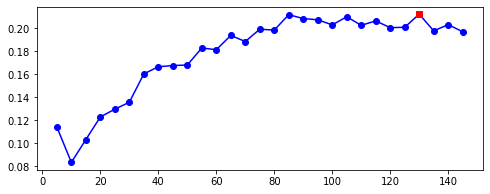

In [65]:
best_idx = np.argmax(scores)
best_k = range(5, 150, 5)[best_idx]

plt.figure(figsize=(8, 3))
plt.plot(range(5, 150, 5), scores, "bo-")
plt.plot(best_k, scores[best_idx], "rs")
plt.show()

In [66]:
kms = []
for n_clusters in range(best_k - 5, best_k + 5):
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train_pca)
    kms.append(km)

In [67]:
best_k

130

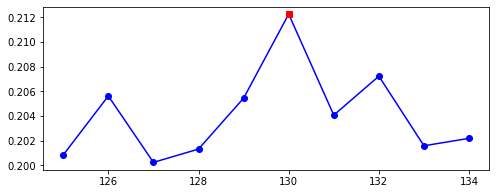

In [68]:
scores = [silhouette_score(X_train_pca, model.labels_) for model in kms]

best_best_idx = np.argmax(scores)
best_best_k = range(best_k - 5, best_k + 5)[best_best_idx]

plt.figure(figsize=(8, 3))
plt.plot(range(best_k - 5, best_k + 5), scores, "bo-")
plt.plot(best_best_k, scores[best_best_idx], "rs")
plt.show()

In [69]:
# here we can see that it has created 130 clusters even though we know that there is only about 40 classes

In [70]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
clf.fit(X_train_pca, y_train)
clf.score(X_val_pca, y_val)

0.7166666666666667

In [71]:
best_model = kms[best_best_idx]

In [72]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_val_pca)
X_test_reduced = best_model.transform(X_test_pca)

In [73]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
clf.score(X_valid_reduced, y_val)

0.65

In [74]:
from sklearn.pipeline import Pipeline

best_score = 0
best_model = None
k_range = range(5, 150, 5)
for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])

    pipeline.fit(X_train_pca, y_train)
    score = pipeline.score(X_val_pca, y_val)
    if score > best_score:
        best_score = score
        best_model = pipeline

In [75]:
best_score

0.7166666666666667

In [76]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_val_extended = np.c_[X_val_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [86]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_val_extended, y_val)

0.75

In [87]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=40, random_state=42)
y_pred = bgm.fit_predict(X_train_pca)

In [88]:
n_gen_faces = 20
gen_faces_pca, y_gen_faces = bgm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_pca)

In [89]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

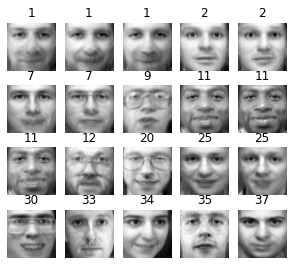

In [90]:
plot_faces(gen_faces, y_gen_faces)

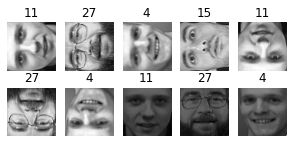

In [91]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64**2)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64**2)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [93]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [94]:
bgm.score_samples(X_bad_faces_pca)
# these are considered to be very unlikely

array([-52032.82524268, -53888.72905626, -33266.04451197, -40385.1655845 ,
       -69415.33814706, -69937.28710874, -43299.69402324, -14968.58282382,
       -15085.5061478 , -14088.62812424])

In [95]:
bgm.score_samples(X_train_pca[:10])

array([418.6875246 , 417.6391862 , 414.50984563, 398.20856331,
       408.8791237 , 416.89711513, 418.32218875, 413.66620886,
       411.93073093, 408.18516552])

In [96]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_recon = pca.inverse_transform(X_pca)
    mse = np.square(X_recon - X).mean(axis=-1)
    return mse

In [97]:
reconstruction_errors(pca, X_train).mean()

0.00018516115

In [98]:
reconstruction_errors(pca, X_bad_faces).mean()
# bad faces have much higher error

0.006159472

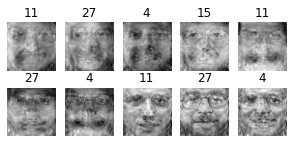

In [99]:
X_bad_faces_recon = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_recon, y_bad)